# Fitting Saturation-based Simulation Data
In this notebook, we try to fit intensity data generated using a saturation based method. The mu_a for each of the maternal and fetal layer are based on a set oxygen saturation and HB concentration. The impact of all other pigments on mu_a are ignored. The goal for this experiment is to see if we can train a model to determine these hidden variables - the Hb conc. and the saturation just by looking at the intensity values!

# Instructions
I have the parameter search in one of the cells. Run eveerything above it to be able to run that cell.
If you don't want to search, ignore that cell and run everything above and below. 

# Issues
1. Only the mu_a's are changed, not any of the other properties! 
2. Fetal performance is not nearly as good as maternal. This could be due to the noise in the far ends of the plots. Maybe interpolation would help?
3. Fetal errors: Sat: ~3% Sat., Conc: ~1.9


# Notes
1. Using interpolated values seems to make the fitting more stable. Not better however.
2. Maternal is very good.
3. Fetal just estimates a mean!

# Things to Try
1. Fetal | Maternal = known

In [11]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, create_perceptron_model, train_model_wtih_reporting
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models.custom_models import TwoChannelCNN
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import os
import torchinfo
# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [12]:
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity.pkl')
equidistance_detector_normalization(data)

# Interpolate intensity to remove noise
data = interpolate_exp(data, weights=[1, 1])
data['Intensity'] = data['Interpolated Intensity']

data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log
data.head()

,SDD,Intensity,Wave Int,Uterus Thickness,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,Interpolated Intensity
0,10,-7.713517,2.0,5.0,26.0,12.0,0.9,11.0,0.9,1.934118e-08
1,14,-6.976572,2.0,5.0,26.0,12.0,0.9,11.0,0.9,1.055428e-07
2,19,-9.016530,2.0,5.0,26.0,12.0,0.9,11.0,0.9,9.626533e-10
3,23,-11.864497,2.0,5.0,26.0,12.0,0.9,11.0,0.9,1.366164e-12
4,28,-16.251144,2.0,5.0,26.0,12.0,0.9,11.0,0.9,5.608625e-17


In [13]:
data = pd.pivot(data, index=['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"], columns=["SDD", "Wave Int"], values="Intensity").reset_index()
data.dropna(inplace=True)   # Slight coding mistake, not all waveints have both wv1 and 2
data.head()

SDD,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10,14,19,23,28,...,55,59,64,68,73,77,82,86,91,95
Wave Int,,,,,,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1875,14.0,12.0,0.9,11.0,0.900,-4.956550,-8.095053,-11.972466,-14.868525,-18.177311,...,-20.727545,-21.451145,-22.306962,-22.959020,-23.740171,-24.342051,-25.070109,-25.635890,-26.325392,-26.864754
1876,14.0,12.0,0.9,11.0,0.925,-4.957389,-8.094254,-11.971331,-14.867792,-18.177502,...,-20.689520,-21.407113,-22.255819,-22.902534,-23.677462,-24.274738,-24.997516,-25.559453,-26.244622,-26.780891
1877,14.0,12.0,0.9,11.0,0.950,-4.958217,-8.093461,-11.970208,-14.867067,-18.177692,...,-20.651862,-21.363215,-22.204378,-22.845298,-23.613306,-24.205317,-24.921865,-25.479102,-26.158753,-26.690893
1878,14.0,12.0,0.9,11.0,0.975,-4.959036,-8.092677,-11.969096,-14.866349,-18.177882,...,-20.614909,-21.319674,-22.152654,-22.787098,-23.547133,-24.132881,-24.841760,-25.392998,-26.065331,-26.591763
1879,14.0,12.0,0.9,11.0,1.000,-4.959844,-8.091900,-11.967996,-14.865638,-18.178072,...,-20.578984,-21.276683,-22.100584,-22.727604,-23.478202,-24.056295,-24.755501,-25.298933,-25.961439,-26.479966


In [14]:
# Rename multi-index columns
data.columns = ['_'.join([str(col[0]), str(col[1])]) if col[1] != '' else col[0] for col in data.columns]

# y_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]
y_columns = ['Fetal Saturation']
x_columns = list(filter(lambda X: '_' in X, data.columns))

# Pass in maternal info

x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]

In [15]:
# filtered_fitting_param_table = fitting_param_table[fitting_param_table['Wave Int'] == 2.0]
# x_scaler = preprocessing.StandardScaler()
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

# Manual log(intensity) normalization
# data[x_columns] /= 100.0    # stddev.   (Actual value is higher but let's keep it here for now)
# data[x_columns] += 0.5  # unit var : mean
data[x_columns[:-2]] /= 100.0    # stddev.   (Actual value is higher but let's keep it here for now)
data[x_columns[:-2]] += 0.5  # unit var : mean
data["Maternal Saturation"] -= 0.5 
data["Maternal Hb Concentration"] /= 20 
data["Maternal Hb Concentration"] -= 0.5 


In [16]:
# Print Out Scaler values
print(f'Y scale mean {y_scaler.mean_}')
print(f'Y scale var {y_scaler.var_}')

Y scale mean [0.95]
Y scale var [0.00125]


In [17]:
data[y_columns].value_counts()

Fetal Saturation
-1.414214           375
-0.707107           375
 0.000000           375
 0.707107           375
 1.414214           375
dtype: int64

In [18]:
test = data[x_columns].describe()

In [19]:
# Custom Train Function 
def train_model2(config, epoch=100):
    np.random.seed(70)  # Set seed for consistentcy
    params = {
        'batch_size': config['batch_size'], 'shuffle': True, 'num_workers': 2
    }
    train, val = generate_data_loaders(data, params, x_columns, y_columns, 0.8)
    # model = create_perceptron_model(config['model'])
    model = create_perceptron_model([42, 8, 1])
    # model = TwoChannelCNN(40, 4, 5, [4, 1])
    criterion = nn.MSELoss()
    optimizer = SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])
    # optimizer = Adam(model.parameters(), lr=config["lr"], betas=[config["b1"], config["b2"]])
    train_loss, val_loss = train_model_wtih_reporting(model, optimizer=optimizer, criterion=criterion, train_loader=train, validation_loader=val, epochs=epoch)

In [20]:
# Hyper Parameter Search 
config = {
    "lr" : tune.loguniform(1e-5, 1e-3),
    # "b1" : tune.uniform(0.3, 1.0),
    # "b2" : tune.uniform(0.3, 1.0),
    "batch_size": tune.choice([64, 32, 16]),
    # "model": tune.choice([[40, 5, 1], [40, 10, 1], [40, 5, 2, 1]]),
    "momentum": tune.choice([0.9, 0.95, 0.99]),
}
scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=50, grace_period=5, reduction_factor=2)
reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
result = tune.run(train_model2, config=config, scheduler=scheduler, progress_reporter=reporter,
                  num_samples=50, resources_per_trial={"cpu": 4, "gpu": 0.05},)

best_trial = result.get_best_trial("combined_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["val_loss"]))
print("Best trial final train loss: {}".format(
    best_trial.last_result["train_loss"]))


== Status ==
Current time: 2023-06-03 01:32:37 (running for 00:00:00.20)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 4.0/64 CPUs, 0.05/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-06-03_01-32-37
Number of trials: 50/50 (49 PENDING, 1 RUNNING)
+--------------------------+----------+-----------------------+--------------+-------------+------------+
| Trial name               | status   | loc                   |   batch_size |          lr |   momentum |
|--------------------------+----------+-----------------------+--------------+-------------+------------|
| train_model2_32381_00000 | RUNNING  | 169.237.32.34:1531044 |           64 | 0.000591844 |       0.95 |
| train_model2_32381_00001 | PENDING  |                       |           16 | 0.000821425 |       0.9  |
| train_model2_32381_00002 | PENDING  |                       |          

Trial name,combined_loss,date,done,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,train_loss,training_iteration,trial_id,val_loss
train_model2_32381_00000,2.07914,2023-06-03_01-32-41,False,blueberry,1,169.237.32.34,1531044,2.63773,2.63773,2.63773,1685781161,1.06592,1,32381_00000,1.01321
train_model2_32381_00001,2.01207,2023-06-03_01-32-44,False,blueberry,1,169.237.32.34,1531093,4.03336,4.03336,4.03336,1685781164,1.01334,1,32381_00001,0.998729
train_model2_32381_00002,2.01876,2023-06-03_01-32-44,False,blueberry,1,169.237.32.34,1531095,4.17929,4.17929,4.17929,1685781164,1.00946,1,32381_00002,1.0093
train_model2_32381_00005,2.02096,2023-06-03_01-32-44,False,blueberry,1,169.237.32.34,1531101,3.59609,3.59609,3.59609,1685781164,1.01098,1,32381_00005,1.00998
train_model2_32381_00008,2.0964,2023-06-03_01-32-44,False,blueberry,1,169.237.32.34,1531108,3.91114,3.91114,3.91114,1685781164,1.04343,1,32381_00008,1.05297


== Status ==
Current time: 2023-06-03 01:32:42 (running for 00:00:05.28)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 40.000: None | Iter 20.000: None | Iter 10.000: None | Iter 5.000: None
Logical resource usage: 64.0/64 CPUs, 0.8000000000000002/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-06-03_01-32-37
Number of trials: 50/50 (34 PENDING, 16 RUNNING)
+--------------------------+----------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status   | loc                   |   batch_size |          lr |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+----------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------|
| train_model2_32381_00000 | RUNNING  | 169.237.32.34:1531044 

2023-06-03 01:33:49,088	INFO tune.py:945 -- Total run time: 71.44 seconds (71.42 seconds for the tuning loop).


== Status ==
Current time: 2023-06-03 01:33:49 (running for 00:01:11.42)
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 40.000: -2.0002539629737535 | Iter 20.000: -2.000166897972425 | Iter 10.000: -2.000398862737079 | Iter 5.000: -2.0076264536391335
Logical resource usage: 0/64 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-06-03_01-32-37
Number of trials: 50/50 (50 TERMINATED)
+--------------------------+------------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status     | loc                   |   batch_size |          lr |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+------------+-----------------------+--------------+-------------+------------+--------------+------------+-----------------+----------------------|
| train_model2_32381_00000

<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

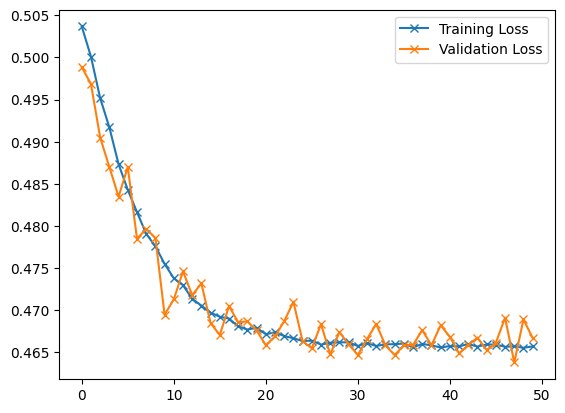

In [22]:
# Train Model with the given params.
np.random.seed(70)  # Set seed for consistentcy
params = {
    'batch_size': 32, 'shuffle': True, 'num_workers': 2
}
train, val = generate_data_loaders(data, params, x_columns, y_columns, 0.8)
model = create_perceptron_model([42, 5, 2, 1])
# model = TwoChannelCNN(42, 4, 3, [2, 1])
# criterion = nn.MSELoss()
criterion = nn.HuberLoss()
# optimizer = Adam(model.parameters(), lr=0.0009, betas=[0.935, 0.701])
optimizer = SGD(model.parameters(), lr=0.0001, momentum=0.95)
# CUDA_VISIBLE is already set to only see one GPU
train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=50, gpu_to_use=0)
plt.figure()
plt.plot(train_loss, label='Training Loss', marker='x')
plt.plot(validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

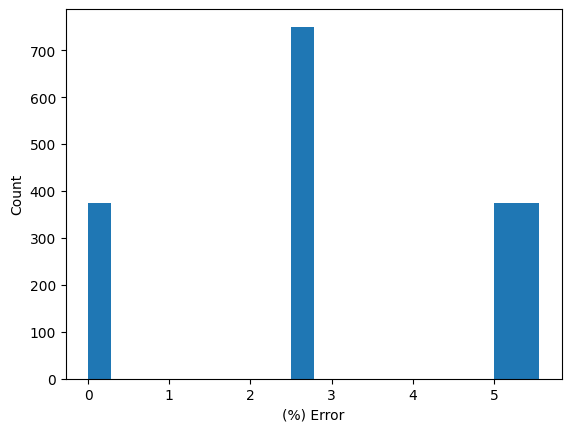

In [23]:
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[x_columns].values, dtype=torch.float).cuda()
    predictions = model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions).flatten()
    y_data = data[y_columns].to_numpy()
    y_data = y_scaler.inverse_transform(y_data).flatten()
    absolute_error = np.abs(y_data - predictions)
    error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error/y_data * 100})
plt.figure()
error_df['%tage'].plot.hist(bins=20)
plt.xlabel('(%) Error')
plt.ylabel('Count')
plt.show()

In [51]:
# Top Bad Samples
VIEW_TOP_N = 20
worst_errors = error_df['%tage'].argsort()[::-1][:VIEW_TOP_N]
with pd.option_context("display.max_rows", None):
    display(data[['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]].iloc[worst_errors, :])

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation
625,26.0,12.0,0.900,11.0,-1.414214
1100,26.0,15.0,1.000,11.0,-1.414214
1625,30.0,15.0,0.900,11.0,-1.414214
1120,26.0,15.0,1.000,17.0,-1.414214
1115,26.0,15.0,1.000,15.5,-1.414214
1630,30.0,15.0,0.900,12.5,-1.414214
1110,26.0,15.0,1.000,14.0,-1.414214
1105,26.0,15.0,1.000,12.5,-1.414214
1635,30.0,15.0,0.900,14.0,-1.414214
1095,26.0,15.0,0.975,17.0,-1.414214


In [45]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {validation_loss[-1] * y_scaler.var_ }')

Train Error(non-normalized): [0.00124471]
Validation Error(non-normalized): [0.00123934]


In [52]:
# Model Info
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
TwoChannelCNN                            --
├─Conv1d: 1-1                            12
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       3,080
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       820
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       84
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       10
│    └─ReLU: 2-8                         --
│    └─Linear: 2-9                       3
│    └─Flatten: 2-10                     --
Total params: 4,009
Trainable params: 4,009
Non-trainable params: 0